<a href="https://colab.research.google.com/github/dassus98/banking_churn/blob/main/Banking_Churn_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuration

In [63]:
# Standard Libraries & Utilities
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

# ML models & Sampling
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_auc_score, f1_score, precision_recall_curve
)
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Configuration & Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
pd.set_option('display.float_format', '{:.2f}'.format)

# Warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data Preparation

In [64]:
# Loading data
df = pd.read_csv('banking_churn.csv', header=0)

# Inspecting data
print(f'Shape: {df.shape}')
print(f'Columns: {df.columns.tolist()}')

# Dropping irrelevant columns
drop_cols = ['RowNumber', 'CustomerId', 'Surname']
df = df.drop(columns = drop_cols)

# Defining features
X = df.drop(columns = ['Exited'])
y = df['Exited']

# Splitting features
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size = 0.2, 
    random_state = RANDOM_SEED, 
    stratify = y
    )

Shape: (10000, 14)
Columns: ['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


# Feature Engineering

In [65]:
from sklearn.base import BaseEstimator, TransformerMixin

# Defining custom transformer for feature engineering
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        # Interaction feature: Wealth per product
        # Exploring whether high savings + few products = saver
        # Differentiates passive savers from active product users
        X['BalancePerProduct'] = X['Balance'] / X['NumOfProducts']

        # Interaction feature: Tenure / Age Ratio
        # Exploring whether young customers + high tenure = loyal customer base
        X['TenureAgeRatio'] = X['Tenure'] / X['Age']

        # Interaction feature: Is Senior
        # Binning age to help tree models
        X['IsSenior'] = (X['Age'] > 60).astype(int)

        return X
    
# Defining lists of columns
numeric_features = [
    'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 
    'IsActiveMember', 'EstimatedSalary', 'BalancePerProduct', 'TenureAgeRatio', 'IsSenior'
]

categorical_features = [
    'Geography', 'Gender'
]

# Creating column transformer
preprocessor = ColumnTransformer(
    transformers = [
        # Scaling numeric values to help with convergence (important for SVM)
        ('num', StandardScaler(), numeric_features),

        # One-hot encoding categorical features
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    verbose_feature_names_out = False
)

print("Preprocessing Pipeline Completed.")

Preprocessing Pipeline Completed.


# Developing Basic Pipeline with XGBoost and SMOTE

In [66]:
# Building final pipeline
model_pipeline = ImbPipeline(steps = [
    # Creating new features
    ('feature_engineering', FeatureEngineer()),

    # Transform data
    ('preprocessor', preprocessor),
    
    # Use SMOTE to handle class imbalance
    ('smote', SMOTE(random_state=RANDOM_SEED)),

    # XGBoost
    ('classifier', XGBClassifier(
        n_estimators = 100,
        learning_rate = 0.1,
        max_depth = 4,
        random_state = RANDOM_SEED,
        n_jobs = -1,
        eval_metric = 'logloss'
    ))
])

print('Model Pipeline Completed.')

Model Pipeline Completed.


# Training & Evaluating the XGBoost Classifier

Model training in process...

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1593
           1       0.64      0.64      0.64       407

    accuracy                           0.85      2000
   macro avg       0.77      0.77      0.77      2000
weighted avg       0.85      0.85      0.85      2000


Confusion Matrix


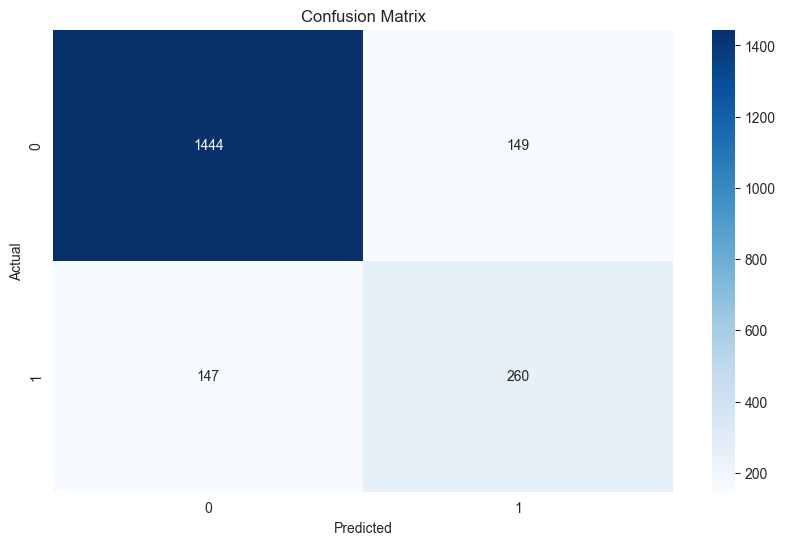

In [67]:
print('Model training in process...')
model_pipeline.fit(X_train, y_train)

# Predicting outcomes
y_pred = model_pipeline.predict(X_test)
y_prob = model_pipeline.predict_proba(X_test)[:, 1]

# Printing metrics
print('\nClassification Report')
print(classification_report(y_test, y_pred))

print('\nConfusion Matrix')
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Evaluating Real-World Business Consequences

In [68]:
# Calculating business impact of churn
# Let's assume that the retention cost is $250 and the churn cost is $5000
# So it costs 5% of the churn to try and retain a customer

tn, fp, fn, tp = conf_matrix.ravel()

# Churn Cost if we take no action to prevent customer loss
cost_do_nothing = (fn + tp) * 5000

# Adding up the Retention Cost + Missed Opportunities + Churn Cost
cost_model = (fp * 250) + (tp * 250) + (fn * 5000)

savings = cost_do_nothing - cost_model

print(f'\nROI Analysis')
print(f'Cost of Inaction: ${cost_do_nothing:,.0f}')
print(f'Cost of Retention: ${cost_model:,.0f}')
print(f'Savings: ${savings:,.0f}')


ROI Analysis
Cost of Inaction: $2,035,000
Cost of Retention: $837,250
Savings: $1,197,750


In [69]:

print(f'\nROI Analysis')
print(f'Cost of Inaction: ${cost_do_nothing:,.0f}')
print(f'Cost of Retention: ${cost_model:,.0f}')
print(f'Savings: ${savings:,.0f}')


ROI Analysis
Cost of Inaction: $2,035,000
Cost of Retention: $837,250
Savings: $1,197,750


# Compaing Alternative Models

Model training in process...
Model LogisticRegression completed. | AUC: 0.7802
Model RandomForest completed. | AUC: 0.8474
Model SVM completed. | AUC: 0.8380
Model XGBoost completed. | AUC: 0.8430


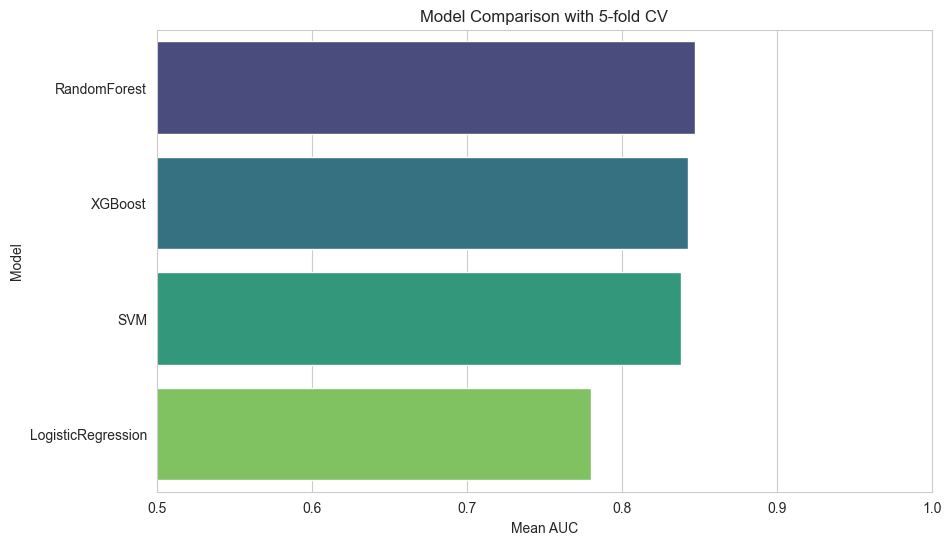

In [70]:
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

models = {
    "LogisticRegression": LogisticRegression(solver = 'liblinear', random_state = RANDOM_SEED),
    "RandomForest": RandomForestClassifier(n_estimators = 100, random_state = RANDOM_SEED),
    "SVM": SVC(probability = True, random_state = RANDOM_SEED),
    "XGBoost": XGBClassifier(n_estimators = 100, eval_metric = 'logloss', random_state = RANDOM_SEED)
}

results = []

print('Model training in process...')

for name, model in models.items():
    # Creating pipeline
    current_pipeline = clone(model_pipeline)
    current_pipeline.steps.pop(-1)
    current_pipeline.steps.append(('classifier', model))

    # Including cross-validation with 5 folds
    # Optimizing for ROC-AUC to measure model ability to distinguish classes
    cv_scores = cross_val_score(
        current_pipeline,
        X_train,
        y_train,
        cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = RANDOM_SEED),
        scoring = 'roc_auc',
        n_jobs = -1
    )

    # Logging results
    results.append({
        'Model': name,
        'Mean AUC': cv_scores.mean(),
        'Standard Deviation': cv_scores.std()
    })

    print(f'Model {name} completed. | AUC: {cv_scores.mean():.4f}')

# Creating dataframe with results
results_df = pd.DataFrame(results).sort_values(by = 'Mean AUC', ascending = False)

# Showing comparison of results
sns.barplot(data = results_df, x = 'Mean AUC', y = 'Model', palette = 'viridis')
plt.title('Model Comparison with 5-fold CV')
plt.xlim(0.5, 1)
plt.show()

# Tuning Hyperparameters of XGBoost Model with Bayesian Optimization

In [71]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

print('Starting Bayesian Optimization for XGBoost...')

# Defining the search space
search_spaces = {
    'classifier__learning_rate': Real(0.01, 0.1, prior = 'log-uniform'),
    'classifier__max_depth': Integer(3, 5),
    'classifier__min_child_weight': Integer(5, 10),
    'classifier__gamma': Real(1, 5),
    'classifier__subsample': Real(0.6, 0.8),
    'classifier__colsample_bytree': Real(0.5, 0.8),
    'classifier__scale_pos_weight': Real(2, 5)
}

# Creating search object
opt = BayesSearchCV(
    estimator = model_pipeline,
    search_spaces = search_spaces,
    n_iter = 50,
    cv = 5,
    n_jobs = -1,
    random_state = RANDOM_SEED,
    scoring = 'roc_auc',
    verbose = 1
)

# Searching
opt.fit(X_train, y_train)

print(f'Best AUC Score: {opt.best_score_:.4f}')
print(f'Best Parameters found: {opt.best_params_}')

Starting Bayesian Optimization for XGBoost...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 

# Evaluating Final Models

Test AUC: 0.7934
              precision    recall  f1-score   support

           0       0.94      0.81      0.87      1593
           1       0.51      0.78      0.61       407

    accuracy                           0.80      2000
   macro avg       0.72      0.79      0.74      2000
weighted avg       0.85      0.80      0.81      2000



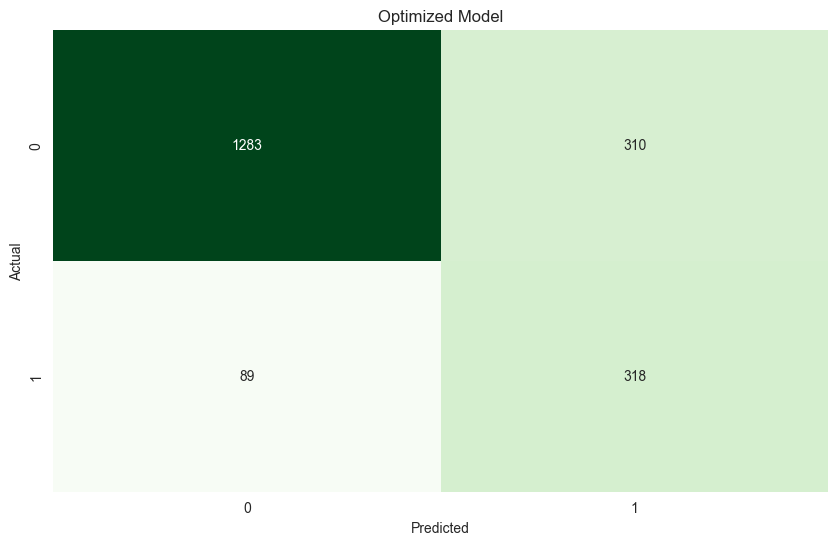

In [72]:
best_model = opt.best_estimator_

# Predicting on test data
y_pred_final = best_model.predict(X_test)
y_prob_final = best_model.predict_proba(X_test)[:, 1]

# Metrics
print(f'Test AUC: {roc_auc_score(y_test, y_pred_final):.4f}')
print(classification_report(y_test, y_pred_final))

# Confusion matrix
plt.figure(figsize = (10, 6))
matrix = confusion_matrix(y_test, y_pred_final)
sns.heatmap(matrix, annot = True, fmt = 'd', cmap = 'Greens', cbar = False)
plt.title('Optimized Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Comments

We were able to crack 0.85 in the ROC-AUC score while training and the test ROC-AUC is 0.79. Let's see the feature importances to see if we can remove some of the least importance features and re-train the model to reduce overfitting.

# Feature Importance

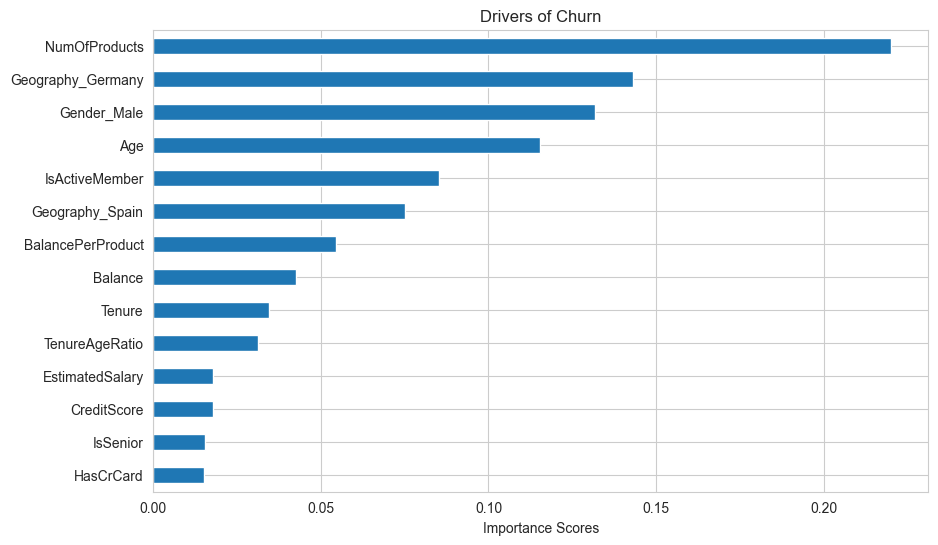

In [73]:
# Extracting feature names from One-Hot Encoder values
feature_names = (numeric_features + list(best_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)))

# Extracting feature importances from XGBoost model
importances = best_model.named_steps['classifier'].feature_importances_

# Graph
plt.figure(figsize = (10, 6))
feat_importances = pd.Series(importances, index = feature_names)
feat_importances.nlargest(15).plot(kind = 'barh').invert_yaxis()
plt.title('Drivers of Churn')
plt.xlabel('Importance Scores')
plt.show()

# Re-Training Model to reduce Overfitting

Shape: (10000, 14)
Columns: ['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']
Model training in process...

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      1593
           1       0.64      0.57      0.60       407

    accuracy                           0.85      2000
   macro avg       0.77      0.74      0.75      2000
weighted avg       0.84      0.85      0.84      2000


Confusion Matrix


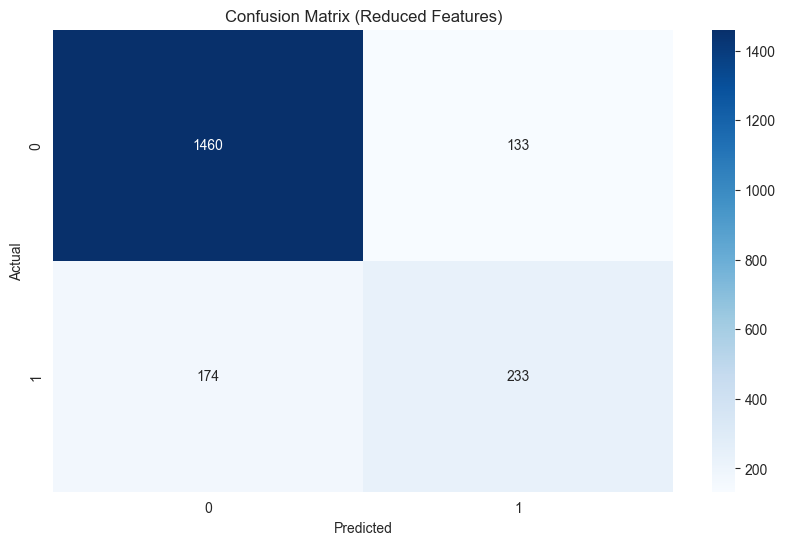

In [82]:
# Since EstimatedSalary and CreditScore are the least important features, let's see if 
# dropping them reduces the noise for the model

# Loading data
df = pd.read_csv('banking_churn.csv', header=0)

# Inspecting data
print(f'Shape: {df.shape}')
print(f'Columns: {df.columns.tolist()}')

# Creating new drop list
new_drop_cols = ['RowNumber', 'CustomerId', 'Surname', 'EstimatedSalary', 'CreditScore', 'HasCrCard']
new_df = df.drop(columns=new_drop_cols)

# Creating new pipeline
new_numeric_features = ['Age', 'Tenure', 'Balance', 'NumOfProducts', 'IsActiveMember',
                        'BalancePerProduct', 'TenureAgeRatio'] 

# Creating new preprocessor
preprocessor_new = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), new_numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    verbose_feature_names_out=False
)

# Creating new model pipeline
new_model_pipeline = ImbPipeline(steps=[
    ('feature_engineering', FeatureEngineer()),
    ('preprocessor', preprocessor_new), # <--- uses the updated feature list
    ('smote', SMOTE(random_state=RANDOM_SEED)),
    ('classifier', XGBClassifier(n_estimators=100, random_state=RANDOM_SEED, n_jobs=-1))
])

# Creating new splits
new_X = new_df.drop(columns=['Exited'])
new_y = new_df['Exited']

new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(
    new_X, new_y, test_size=0.2, random_state=RANDOM_SEED, stratify=new_y
)

# Training new model
print('Model training in process...')
new_model_pipeline.fit(new_X_train, new_y_train)

# Predicting new scores
new_y_pred = new_model_pipeline.predict(new_X_test)
new_y_prob = new_model_pipeline.predict_proba(new_X_test)[:, 1] # Fixed: Pass X_test, not y_test

# Printing new metrics
print('\nClassification Report')
print(classification_report(new_y_test, new_y_pred)) # Fixed: Pass pred, not prob

print('\nConfusion Matrix')
conf_matrix = confusion_matrix(new_y_test, new_y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Reduced Features)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [83]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

print('Starting New Bayesian Optimization for XGBoost...')

# Defining the search space
new_search_spaces = {
    'classifier__learning_rate': Real(0.01, 0.1, prior = 'log-uniform'),
    'classifier__max_depth': Integer(3, 5),
    'classifier__min_child_weight': Integer(5, 10),
    'classifier__gamma': Real(1, 5),
    'classifier__subsample': Real(0.6, 0.8),
    'classifier__colsample_bytree': Real(0.5, 0.8),
    'classifier__scale_pos_weight': Real(2, 5)
}

# Creating search object
new_opt = BayesSearchCV(
    estimator = new_model_pipeline,
    search_spaces = new_search_spaces,
    n_iter = 50,
    cv = 5,
    n_jobs = -1,
    random_state = RANDOM_SEED,
    scoring = 'roc_auc',
    verbose = 1
)

# Searching
new_opt.fit(new_X_train, new_y_train)

print(f'Best AUC Score: {new_opt.best_score_:.4f}')
print(f'Best Parameters found: {new_opt.best_params_}')

Starting New Bayesian Optimization for XGBoost...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fittin

Test AUC: 0.7734
              precision    recall  f1-score   support

           0       0.94      0.75      0.83      1593
           1       0.45      0.80      0.57       407

    accuracy                           0.76      2000
   macro avg       0.69      0.77      0.70      2000
weighted avg       0.84      0.76      0.78      2000



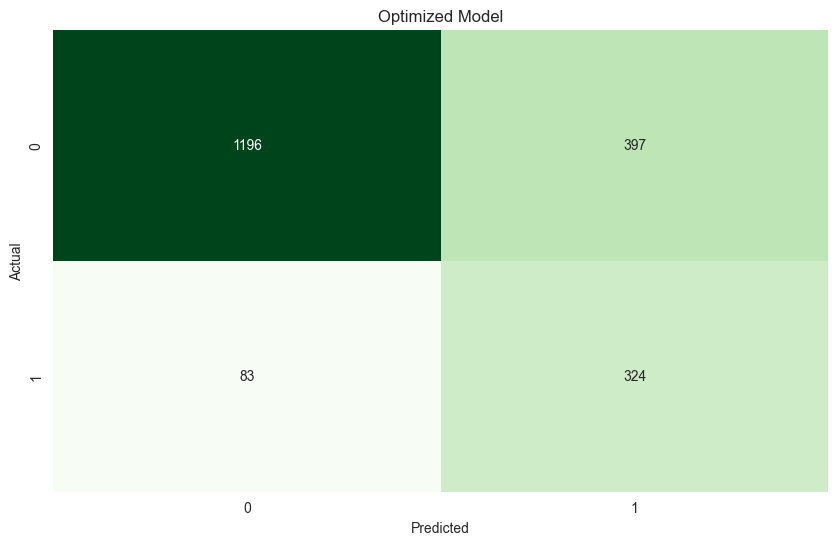

In [86]:
new_best_model = new_opt.best_estimator_

# Predicting on test data
new_y_pred_final = new_best_model.predict(new_X_test)
new_y_prob_final = new_best_model.predict_proba(new_X_test)[:, 1]

# Metrics
print(f'Test AUC: {roc_auc_score(new_y_test, new_y_pred_final):.4f}')
print(classification_report(new_y_test, new_y_pred_final))

# Confusion matrix
plt.figure(figsize = (10, 6))
matrix = confusion_matrix(new_y_test, new_y_pred_final)
sns.heatmap(matrix, annot = True, fmt = 'd', cmap = 'Greens', cbar = False)
plt.title('Optimized Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

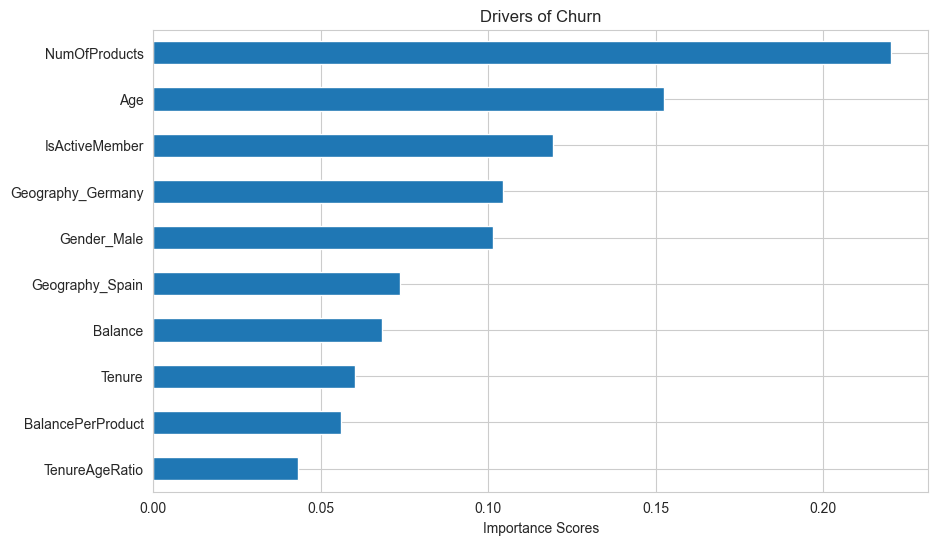

In [87]:
# Extracting feature names from One-Hot Encoder values
new_feature_names = (new_numeric_features + list(new_best_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)))

# Extracting feature importances from XGBoost model
new_importances = new_best_model.named_steps['classifier'].feature_importances_

# Graph
plt.figure(figsize = (10, 6))
new_feat_importances = pd.Series(new_importances, index = new_feature_names)
new_feat_importances.nlargest(15).plot(kind = 'barh').invert_yaxis()
plt.title('Drivers of Churn')
plt.xlabel('Importance Scores')
plt.show()

## Comments

Looks like removing features was not a good idea! Noise reduction strategy didn't work. Probably best to stick with the original model and move on.

Perhaps in the future, more interaction features or better feature engineering could reveal greater patterns in the data.